## Steganography

Steganography is hiding a secret message in another message. Steganography is also used to hide a small message within the noisy regions of a larger image. This is an pytorch implementation of "Hiding Images in Plain Sight: Deep Steganography, by Shumeet Baluja (Google)", at NIPS 2017. The paper is available [here](https://papers.nips.cc/paper/6802-hiding-images-in-plain-sight-deep-steganography).

Let $x$ be the original image, $y$ is the secret image, then $z = E(x, y)$ is the encrypted image, $E$ is the encryption function and $D$ is the decryption function. The model minimizes 

$$\min_{E, D} \|x - E(x,y)\| + \gamma \|y - D(z)\|$$


## Result

For easier illustration of this concept, I will first show the result of my model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

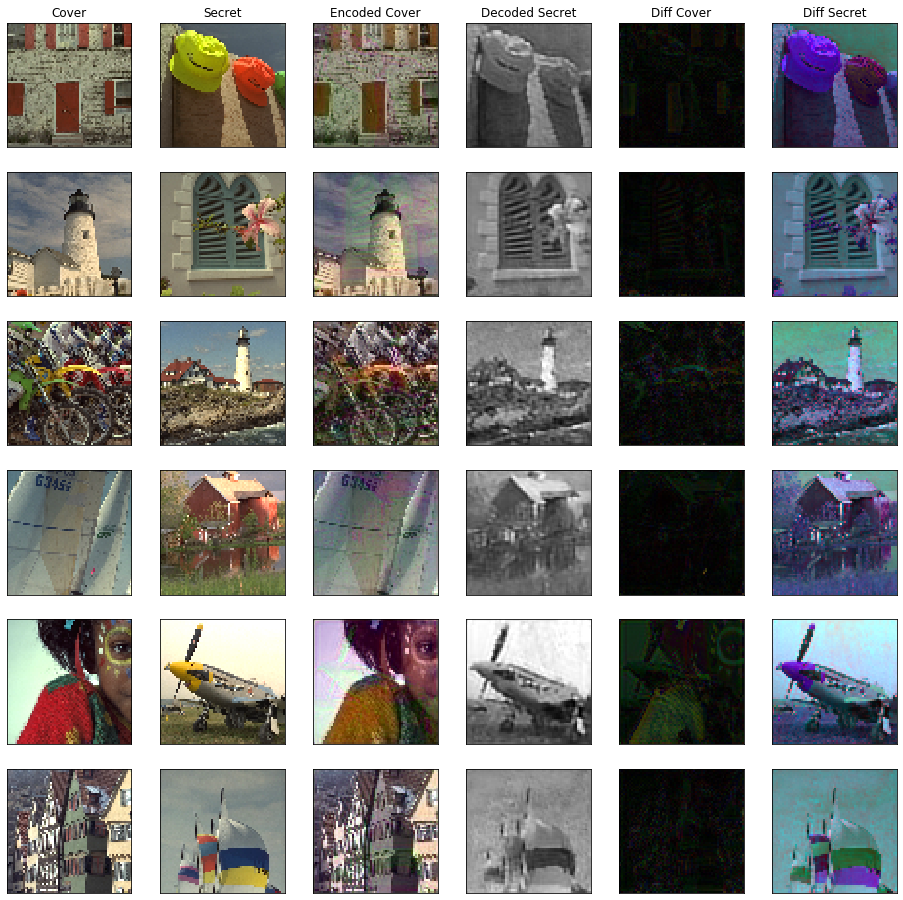

In [73]:
# Number of secret and cover pairs to show.
n = 6
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)


# display test Result
plt.figure(1,figsize=(16,16))
for i, idx in zip(range(6),range(6)):
    n_col = 6 if SHOW_DIFF else 4
    show_image(test_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
    #input_S
    show_image(tmpS[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    show_image(encoded_image[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')


## Dependencies

In [35]:
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

import numpy as np
import os
import cv2
import random
import scipy.misc
from tqdm import *

%matplotlib inline

## Config

In [9]:
DATA_DIR = "./data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

## Dataset creation
The Dataset we used is Tiny ImageNet Visual Recognition Challenge. It can be downloaded [here](https://tiny-imagenet.herokuapp.com/).

Our training set is made of a random subset of images from all 200 classes.

In [41]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        if c == '.DS_Store':
            continue
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs:
        if img_name_i == '.DS_Store':
            continue
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [42]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [43]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
org_input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [28]:
# Implement DCT to reduce the information on secret images

from scipy.fftpack import dct, idct
input_S = dct(org_input_S, norm='ortho')

print("Shape of secret =", input_S.shape)


Shape of secret = (1000, 64, 64, 3)


In [45]:
# For test files processing
tmpS = X_test[0:X_test.shape[0]//2]
test_C = X_test[X_test.shape[0]//2:]
test_S = dct(tmpS,norm='ortho')
print(test_C.shape, test_S.shape)


(12, 64, 64, 3) (12, 64, 64, 3)


## Model


In [14]:
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss

class encoder(nn.module):
    def __init__(self,in_c,stride, padding):
        super(encoder,self).__init__()
        
        # Preperation network
        self.conv12 = nn.Conv2d(3,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv12 = nn.Conv2d(3,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv13 = nn.Conv2d(3,5,kernel_size=5, padding=(3,3),bias=False)
        
        self.conv21 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv22 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv23 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        # Hiding network
        self.conv31 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv32 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv33 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        self.conv41 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv42 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv43 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        self.conv51 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv52 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv53 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        self.conv61 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv62 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv63 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        self.conv71 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv72 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv73 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        # output layer
        self.conv_out = nn.Conv2d(65,3,kernel_size=3, padding=(1,1),bias=False)
        
    def forward(self,xs, xc):
        '''
        Input : xc - cover image (N,3,64,64)
                xs - secret image (N,3,64,64) where N = Batch size
        Output : Hidden image (N,3,64,64)
        '''
        # preperation network
        x1 = F.relu(self.conv11(xs))
        x2 = F.relu(self.conv12(xs))
        x3 = F.relu(self.conv13(xs))
        # tensor size (N,65,64,64)
        xs = torch.cat((x1,x2,x3))
        
        x1 = F.relu(self.conv21(xs))
        x2 = F.relu(self.conv22(xs))
        x3 = F.relu(self.conv23(xs))
        xs = torch.cat((x1,x2,x3))
        
        xs = torch.cat((xc,xs))
        # hiding network
        x1 = F.relu(self.conv31(xs))
        x2 = F.relu(self.conv32(xs))
        x3 = F.relu(self.conv33(xs))
        xs = torch.cat((x1,x2,x3))
        
        x1 = F.relu(self.conv31(xs))
        x2 = F.relu(self.conv32(xs))
        x3 = F.relu(self.conv33(xs))
        xs = torch.cat((x1,x2,x3))
                
        x1 = F.relu(self.conv41(xs))
        x2 = F.relu(self.conv42(xs))
        x3 = F.relu(self.conv43(xs))
        xs = torch.cat((x1,x2,x3))
        
        x1 = F.relu(self.conv51(xs))
        x2 = F.relu(self.conv52(xs))
        x3 = F.relu(self.conv53(xs))
        xs = torch.cat((x1,x2,x3))
        
        x1 = F.relu(self.conv61(xs))
        x2 = F.relu(self.conv62(xs))
        x3 = F.relu(self.conv63(xs))
        xs = torch.cat((x1,x2,x3))
        
        return self.conv_out(xs)
class decoder(nn.module):
    def __init__(self):
        super(decoder,self).__init__()
        
        # Preperation network
        self.conv12 = nn.Conv2d(3,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv12 = nn.Conv2d(3,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv13 = nn.Conv2d(3,5,kernel_size=5, padding=(3,3),bias=False)
        
        self.conv21 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv22 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv23 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        # Hiding network
        self.conv31 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv32 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv33 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        self.conv41 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv42 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv43 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        self.conv51 = nn.Conv2d(65,50,kernel_size=3, padding=(1,1),bias=False)
        self.conv52 = nn.Conv2d(65,10,kernel_size=4, padding=(2,2),bias=False)
        self.conv53 = nn.Conv2d(65,5,kernel_size=5, padding=(3,3),bias=False)
        
        # output layer
        self.conv_out = nn.Conv2d(65,3,kernel_size=3, padding=(1,1),bias=False)
        
    def forward(self,xs, xc):
        '''
        Input : Hidden image (N,3,64,64)
        Output : Retrieved secret image (N,3,64,64) where N = Batch size
        '''
        # preperation network
        x1 = F.relu(self.conv11(xs))
        x2 = F.relu(self.conv12(xs))
        x3 = F.relu(self.conv13(xs))
        # tensor size (N,65,64,64)
        xs = torch.cat((x1,x2,x3))
        
        x1 = F.relu(self.conv21(xs))
        x2 = F.relu(self.conv22(xs))
        x3 = F.relu(self.conv23(xs))
        xs = torch.cat((x1,x2,x3))
        
        xs = torch.cat((xc,xs))
        # hiding network
        x1 = F.relu(self.conv31(xs))
        x2 = F.relu(self.conv32(xs))
        x3 = F.relu(self.conv33(xs))
        xs = torch.cat((x1,x2,x3))
        
        x1 = F.relu(self.conv31(xs))
        x2 = F.relu(self.conv32(xs))
        x3 = F.relu(self.conv33(xs))
        xs = torch.cat((x1,x2,x3))
                
        x1 = F.relu(self.conv41(xs))
        x2 = F.relu(self.conv42(xs))
        x3 = F.relu(self.conv43(xs))
        xs = torch.cat((x1,x2,x3))
        
        return self.conv_out(xs)

class auto_encoder(nn.module):
    def __init__(self):
        super(auto_encoder,self).__init__() 
        self.encoder = encoder()
        self.decoder = decoder()
        
        return self.encoder, self.decoder, self
    
    def forward(self,xs,xc):
        out_cover = self.encoder(xs,xc)
        out_secret = self.decoder(out_cover)
        
        return out_secret, out_cover

In [ ]:
# Load model
autoencoder_model = autoencoder_model()
autoencoder_model = torch.load('models/final_auto.pkl')
encoder_model = encoder()
encoder_model = torch.load('models/final_encode.pkl')
decoder_model = decoder()
decoder_model = torch.load('models/final_decode.pkl')


## Results

In [72]:
# Retrieve decoded predictions.
result = autoencoder_model([test_S, test_C])
encoded_image = encoder_model([test_S,test_C])
decoded_S, decoded_C = result[...,0:3], result[...,3:6]
decoded_S = idct(decoded_S, norm='ortho')
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - test_S), np.abs(decoded_C - test_C) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

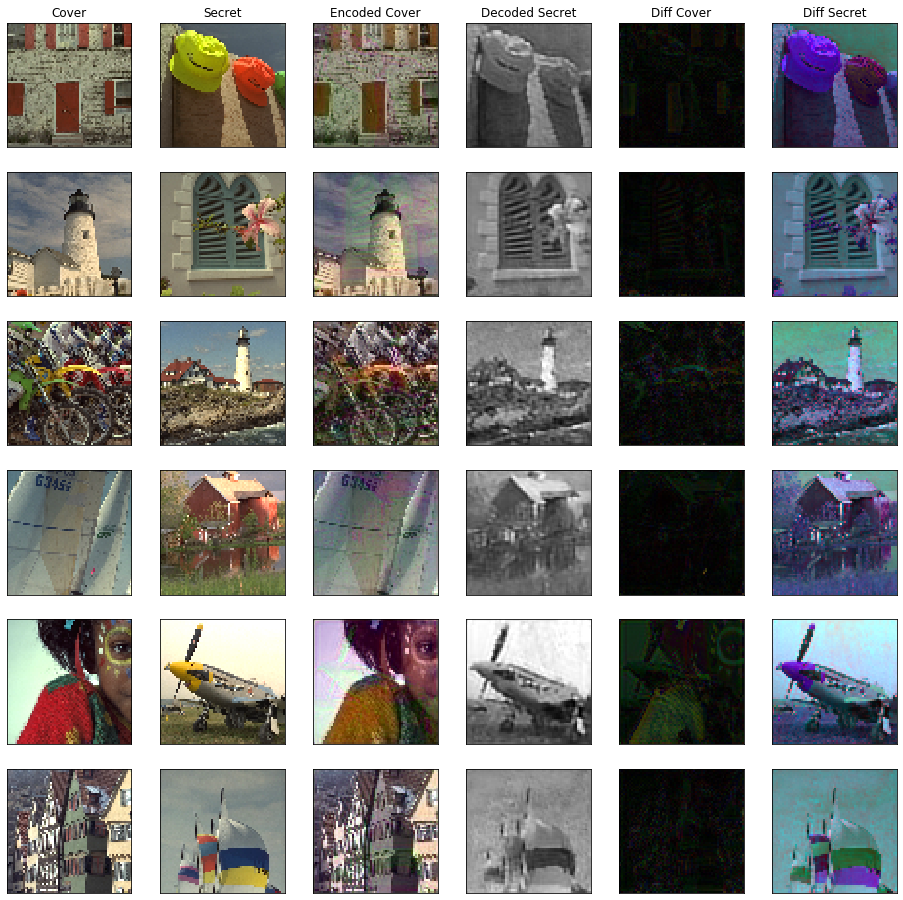

In [73]:
# Configs for results display
# Show images in gray scale
SHOW_GRAY = False

# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)


# display test Result
plt.figure(1,figsize=(16,16))
for i, idx in zip(range(6),range(6)):
    n_col = 6 if SHOW_DIFF else 4
    show_image(test_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
    #input_S
    show_image(tmpS[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    show_image(encoded_image[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')


In [58]:
# Print pixel-wise average errors in a 256 scale.
# S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)
S_error, C_error = pixel_errors(test_S, test_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 110.76211
C error per pixel [0, 255]: 15.748688
